In [ ]:
pip install pymorphy2

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pymorphy2
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score
import re
from tqdm import tqdm_notebook

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"astrowa","key":"cafd98e637a0795500cde39de2ed246e"}'}

In [ ]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 63 Nov 17 09:39 kaggle.json


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c introml2020-3

train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
SEED = 42

### Exploratory Data Analysis and Metric

In [ ]:
train_df = pd.read_csv("train.csv.zip")
test_df = pd.read_csv("test.csv.zip")

In [ ]:
train_df.shape, test_df.shape

((3159633, 2), (2784634, 2))

In [ ]:
train_df.head(70002)

,sentence,language
0,"Pensez à la communication , le discours , les ...",fr
1,"Můžete si ji pronajmout , vzít na splátky , ko...",cs
2,"Každý starosta pochopil , že když mají tyto fo...",cs
3,"Det är ytterligare bevis , men ändå — Jag krit...",sv
4,كان الأمر لا يصدق .,ar
...,...,...
69997,我们可以将左边的方式应用在右边这里吗 ？,zh-cn
69998,我離開南非15年後 ( 認為非洲民族議會將接管南非的是癡人說夢 ) 改變原本絕不再回去的決定...,zh-tw
69999,( Laughter ) You know the pirate tribe is a fa...,en
70000,"Nejdříve jsme ji udělali pro tyto bohaté , roz...",cs


In [ ]:
kek = train_df
n = list(range(62, 65))#58 65

for elem in n:
    print(elem)
    kek = kek[kek.sentence.str.len() != elem].reset_index(drop=True)#0.88

62
63
64


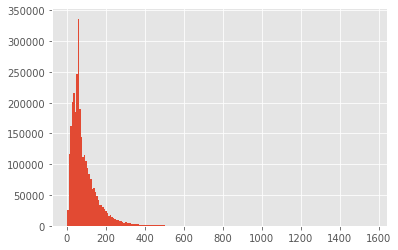

In [ ]:
kek.sentence.str.len().hist(bins=200)

In [ ]:
kek.shape

(3020226, 2)

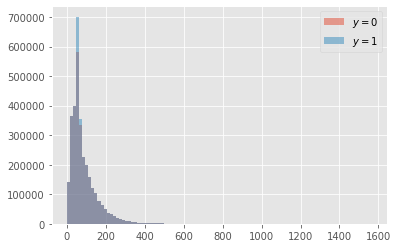

In [ ]:
bins=100
alpha=0.5

plt.hist(kek.sentence.str.len(), alpha=alpha, bins=bins,  label=r'$y = 0$')
plt.hist(train_df.sentence.str.len(), alpha=alpha, bins=bins, label=r'$y = 1$')
plt.legend();

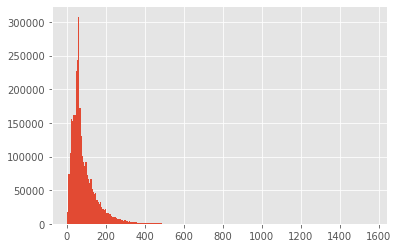

In [ ]:
train_df.sentence.str.len().hist(bins=250)

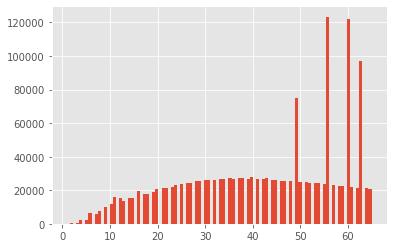

In [ ]:
min_talk_len = 65
max_talk_len = 65

#67 дропнуть надо

kek = train_df[train_df.sentence.str.len() <= max_talk_len].reset_index(drop=True)

kek.sentence.str.len().hist(bins=100);

In [ ]:
train_df = pd.read_csv("train.csv.zip")

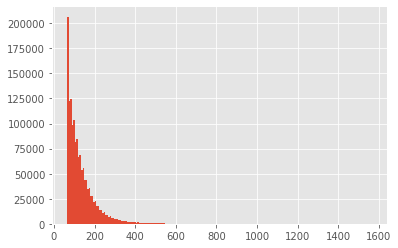

In [ ]:
min_talk_len = 66
max_talk_len = 70

#64 дропнуть надо

train_df1 = train_df[train_df.sentence.str.len() >= min_talk_len].reset_index(drop=True)

train_df1.sentence.str.len().hist(bins=200);

In [ ]:
train_df1.shape

(1510614, 2)

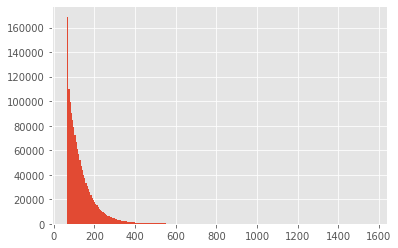

In [ ]:
train_df1.sentence.str.len().hist(bins=250)

In [ ]:
train_df1.shape

(1510614, 2)

In [ ]:
train_df1.sentence[:10]

0    Pensez à la communication , le discours , les ...
1    Můžete si ji pronajmout , vzít na splátky , ko...
2    Každý starosta pochopil , že když mají tyto fo...
3    Det är ytterligare bevis , men ändå — Jag krit...
4    Semua rerumputan itu sekarang menutupi tanah s...
5    Ono što ćete vidjeti - trebat ćete skočiti ovd...
6    После увольнения я решил собрать своих друзей ...
7    この過去の遺産と決別することが これまで以上に急務です 互いを深く隔てる社会的不平等を終わら...
8    Ты знаешь , что это не гнев заставил моё сердц...
9    فكان مصيرهم الفعلي بإنتهاء العصر الحديدي لمجتم...
Name: sentence, dtype: object

In [ ]:
train_df1 = train_df

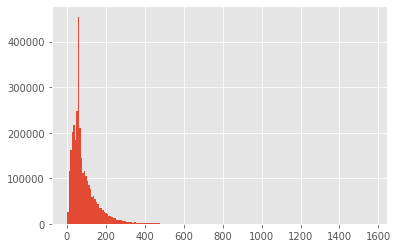

In [ ]:
train_df.sentence.str.len().hist(bins=200)

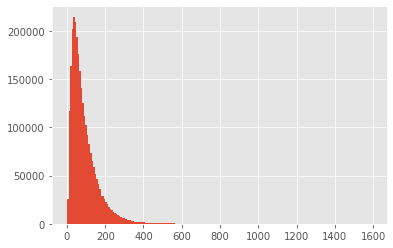

In [ ]:
test_df.sentence.str.len().hist(bins=200)

In [ ]:
lang_count = (
    train_df1.language.value_counts()
    .to_frame()
    .reset_index()
)

lang_count.head()

,index,language
0,ru,181970
1,en,157655
2,fr,148585
3,vi,113193
4,ar,110032


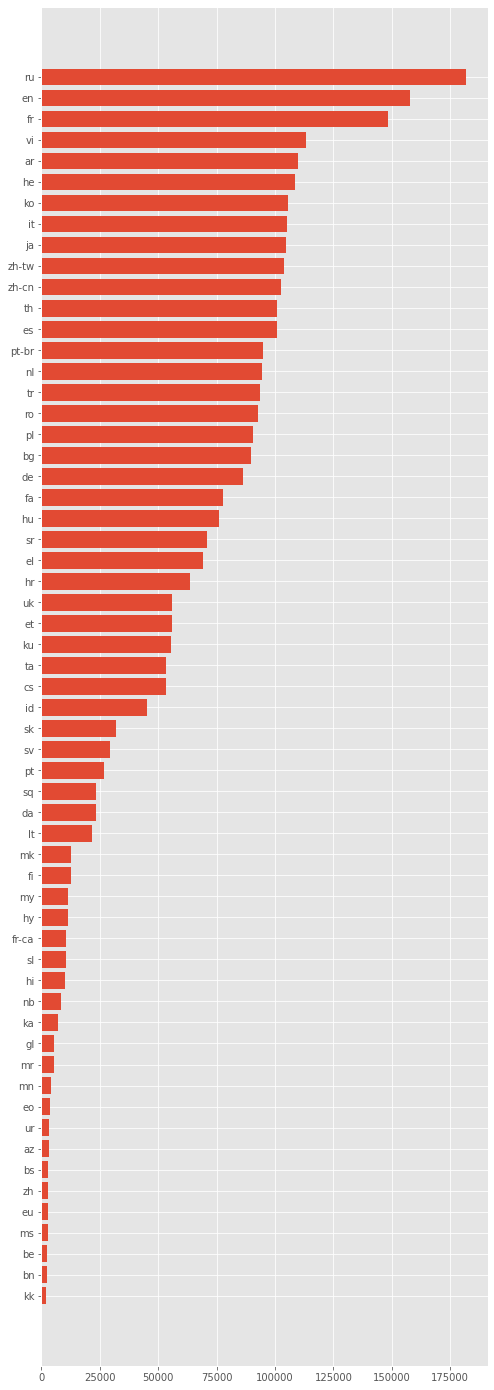

In [ ]:
fig, ax = plt.subplots(figsize=(8,25))

ax.barh(lang_count['index'], lang_count['language'])
ax.invert_yaxis();

In [ ]:
lang_count[lang_count['index'].apply(lambda x: x in {"en", "kk"})]

,index,language
1,en,157655
58,kk,2046


Датасет сильно не сбалансирован по классам, а требуется хорошее качество для всех языков, поэтому метрика в данном соревновании — взвешенная доля правильных ответов:

$$ 
\text{WeightedAccuracy}\left(y, \hat{y}, w\right) = \frac{\displaystyle{\sum_{i=1}^{n}} w_i \cdot \left(y_i == \hat{y}_i\right)}{\displaystyle\sum_{i=1}^{n} w_i } 
$$
Веса выбирались обратно пропорционально количеству примеров соответствующего языка:$$
w\left(\text{"en"}\right) \sim \frac{1}{157655}
$$$$ \dots $$$$
w\left(\text{"kk"}\right) \sim \frac{1}{2046}
$$

Поэтому для валидации можно использовать sklearn.metrics.balanced_accuracy_score

## Model

In [ ]:
train_df1.shape

(3159633, 2)

In [ ]:
x = train_df1.values[:,  0]
label_encoder = LabelEncoder().fit(train_df1.values[:, 1])
y = label_encoder.transform(train_df1.values[:, 1])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stopword_set = set(nltk.corpus.stopwords.words())

In [ ]:
TOKEN_PATTERN = ("(?u)\\b\\w\\w+\\b")

In [ ]:
!pip install pymystem3

In [ ]:
def tokenize(text):
    return re.findall(TOKEN_PATTERN, text.lower())


In [ ]:
lemmatizer = pymorphy2.MorphAnalyzer()

In [ ]:
def lemmatize(token):
    lemmatizer_cache = {}
    if lemmatizer.word_is_known(token):
        if token not in lemmatizer_cache:
            lemmatizer_cache[token] = lemmatizer.parse(token)[0].normal_form
        return lemmatizer_cache[token]
    return token

In [ ]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenize, lowercase=False, max_df=0.6, min_df=2,
                                   token_pattern=("(?u)\\b\\w\\w+\\b"),
                                   preprocessor = lemmatize,
                                   norm='l2')),
    ('model', SGDClassifier(random_state=SEED, loss='log', class_weight='balanced', 
                            verbose=1, alpha = 0.00000001, 
                             n_jobs=-1))
])#max_df 0.4 и 0.5 одинак score 0.873 на трэине >= 68
#попробовать опять чар и поменять класс_weight  (balanced = best)
#альфа была 0.0000001
#попробовать выкинуть небольшую часть. Чем меньше альфа, тем лучше. мин_дф переобучение фикс
#0.000000001 min_df=2 train 0.9421468000761555  test 0.8764933188911219 ЭТО
#попробоваь analyzer = callable or char_wb.  lowercase = False
#stop_words = stopwords_set работает хуже

In [ ]:
%%time

pipe.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1-- Epoch 1

Norm: 729.65, NNZs: 911158, Bias: -6.115016, T: 2527706, Avg. loss: 0.004033
Total training time: 2.37 seconds.
-- Epoch 2
Norm: 6800.95, NNZs: 911158, Bias: -26.693058, T: 2527706, Avg. loss: 0.077334
Total training time: 2.39 seconds.
-- Epoch 2
Norm: 4361.82, NNZs: 911158, Bias: -26.119599, T: 5055412, Avg. loss: 0.013146
Total training time: 4.79 seconds.
-- Epoch 3
Norm: 538.84, NNZs: 911158, Bias: -6.671743, T: 5055412, Avg. loss: 0.000884
Total training time: 4.83 seconds.
-- Epoch 3
Norm: 3192.34, NNZs: 911158, Bias: -31.694183, T: 7583118, Avg. loss: 0.005782
Total training time: 7.17 seconds.
-- Epoch 4
Norm: 484.33, NNZs: 911158, Bias: -6.484658, T: 7583118, Avg. loss: 0.000823
Total training time: 7.36 seconds.
-- Epoch 4
Norm: 2541.08, NNZs: 911158, Bias: -25.981054, T: 10110824, Avg. loss: 0.003344
Total training time: 9.63 seconds.
-- Epoch 5
Norm: 463.72, NNZs: 911158, Bias: -6.565932, T: 10110824, Avg. loss: 0.000834
Total training time: 9.85 seco

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  8.2min


Norm: 2581.29, NNZs: 911158, Bias: -24.318807, T: 5055412, Avg. loss: 0.008824
Total training time: 4.15 seconds.
-- Epoch 3
Norm: 1440.21, NNZs: 911158, Bias: -8.728447, T: 2527706, Avg. loss: 0.005895
Total training time: 2.10 seconds.
-- Epoch 2
Norm: 1920.39, NNZs: 911158, Bias: -19.745775, T: 7583118, Avg. loss: 0.004301
Total training time: 6.17 seconds.
-- Epoch 4
Norm: 904.55, NNZs: 911158, Bias: -9.742520, T: 5055412, Avg. loss: 0.000813
Total training time: 4.16 seconds.
-- Epoch 3
Norm: 1528.11, NNZs: 911158, Bias: -16.740750, T: 10110824, Avg. loss: 0.002529
Total training time: 8.24 seconds.
-- Epoch 5
Norm: 667.62, NNZs: 911158, Bias: -9.386340, T: 7583118, Avg. loss: 0.000453
Total training time: 6.24 seconds.
-- Epoch 4
Norm: 1271.38, NNZs: 911158, Bias: -15.546497, T: 12638530, Avg. loss: 0.001991
Total training time: 10.36 seconds.
-- Epoch 6
Norm: 536.47, NNZs: 911158, Bias: -8.598667, T: 10110824, Avg. loss: 0.000306
Total training time: 8.43 seconds.
-- Epoch 5
Nor

[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed: 10.4min finished


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=False, max_df=0.6, max_features=None,
                                 min_df=2, ngram_range=(1, 1), norm='l2',
                                 preprocessor=<function lemmatize at 0x7efead627f28>,
                                 smooth_idf=True, stop_words=None,
                                 strip_accents=No...
                ('model',
                 SGDClassifier(alpha=1e-08, average=False,
                               class_weight='balanced', early_stopping=False,
                               epsilon=0.1, eta0=0.0, fit_intercept=True,
                               l1_ratio=0.15, learning_rate='optimal',
                          

In [ ]:
predictions = pipe.predict(x_train)

In [ ]:
balanced_accuracy_score(y_train, predictions)#0.9377355499472884

0.9382356831112869

In [ ]:
test_predictions = pipe.predict(x_test)

In [ ]:
balanced_accuracy_score(y_test, test_predictions)#0.8780212507265918

0.8771454937058764

### Попытка бэгинга

In [ ]:
n_estimators = 10
answer = np.zeros((n_estimators, x_test.shape[0]), dtype=int)

In [ ]:
for i in tqdm_notebook(range(n_estimators)):
    index = np.random.choice(np.arange(x_train.shape[0]), x_train.shape[0])
    pipe.fit(x_train[index], y_train[index])
    answer[i] = pipe.predict(x_test)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1-- Epoch 1

Norm: 2626.93, NNZs: 1225759, Bias: -8.097901, T: 2527706, Avg. loss: 0.004492
Total training time: 2.23 seconds.
-- Epoch 2
Norm: 27073.64, NNZs: 1222542, Bias: -101.721068, T: 2527706, Avg. loss: 0.169804
Total training time: 2.24 seconds.
-- Epoch 2
Norm: 22366.71, NNZs: 1223056, Bias: -154.114912, T: 5055412, Avg. loss: 0.037125
Total training time: 4.47 seconds.
-- Epoch 3
Norm: 2105.59, NNZs: 1225759, Bias: -8.942420, T: 5055412, Avg. loss: 0.000677
Total training time: 4.49 seconds.
-- Epoch 3
Norm: 18815.24, NNZs: 1223889, Bias: -149.113460, T: 7583118, Avg. loss: 0.016868
Total training time: 6.67 seconds.
-- Epoch 4
Norm: 1738.78, NNZs: 1225759, Bias: -9.450363, T: 7583118, Avg. loss: 0.000336
Total training time: 6.71 seconds.
-- Epoch 4
Norm: 16067.63, NNZs: 1224920, Bias: -166.066966, T: 10110824, Avg. loss: 0.010412
Total training time: 8.82 seconds.
-- Epoch 5
Norm: 1485.93, NNZs: 1225759, Bias: -9.103700, T: 10110824, Avg. loss: 0.000337
Total trai

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 12.5min


Norm: 835.73, NNZs: 1225759, Bias: -8.089950, T: 70775768, Avg. loss: 0.043446
Total training time: 61.37 seconds.
-- Epoch 29
Norm: 5858.61, NNZs: 1225759, Bias: -50.002397, T: 2527706, Avg. loss: 0.011993
Total training time: 2.17 seconds.
-- Epoch 2
Norm: 829.27, NNZs: 1225759, Bias: -7.988259, T: 73303474, Avg. loss: 0.041969
Total training time: 63.63 seconds.
-- Epoch 30
Norm: 4863.40, NNZs: 1225759, Bias: -49.786191, T: 5055412, Avg. loss: 0.002793
Total training time: 4.29 seconds.
-- Epoch 3
Norm: 823.58, NNZs: 1225759, Bias: -8.188997, T: 75831180, Avg. loss: 0.040733
Total training time: 65.84 seconds.
-- Epoch 31
Norm: 4081.22, NNZs: 1225759, Bias: -45.450737, T: 7583118, Avg. loss: 0.001554
Total training time: 6.44 seconds.
-- Epoch 4
Norm: 818.51, NNZs: 1225759, Bias: -8.235059, T: 78358886, Avg. loss: 0.039276
Total training time: 68.07 seconds.
-- Epoch 32
Norm: 3486.26, NNZs: 1225759, Bias: -38.738201, T: 10110824, Avg. loss: 0.001006
Total training time: 8.59 seconds

[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed: 15.9min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1-- Epoch 1

Norm: 26625.26, NNZs: 1222698, Bias: -60.182143, T: 2527706, Avg. loss: 0.163859
Total training time: 2.10 seconds.
-- Epoch 2
Norm: 2653.63, NNZs: 1226437, Bias: -8.608895, T: 2527706, Avg. loss: 0.004582
Total training time: 2.14 seconds.
-- Epoch 2
Norm: 21589.45, NNZs: 1223407, Bias: -148.840900, T: 5055412, Avg. loss: 0.028132
Total training time: 4.09 seconds.
-- Epoch 3
Norm: 2121.03, NNZs: 1226437, Bias: -8.867986, T: 5055412, Avg. loss: 0.000604
Total training time: 4.15 seconds.
-- Epoch 3
Norm: 18088.62, NNZs: 1224810, Bias: -108.416909, T: 7583118, Avg. loss: 0.013364
Total training time: 6.05 seconds.
-- Epoch 4
Norm: 1742.87, NNZs: 1226437, Bias: -8.675640, T: 7583118, Avg. loss: 0.000357
Total training time: 6.16 seconds.
-- Epoch 4
Norm: 15420.57, NNZs: 1225734, Bias: -122.891448, T: 10110824, Avg. loss: 0.007592
Total training time: 8.04 seconds.
-- Epoch 5
Norm: 1486.47, NNZs: 1226437, Bias: -9.290317, T: 10110824, Avg. loss: 0.000235
Total train

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 11.1min


Norm: 847.67, NNZs: 1226437, Bias: -8.104920, T: 68248062, Avg. loss: 0.045672
Total training time: 52.32 seconds.
-- Epoch 28
Norm: 5958.23, NNZs: 1226437, Bias: -40.190737, T: 2527706, Avg. loss: 0.012552
Total training time: 1.92 seconds.
-- Epoch 2
Norm: 840.35, NNZs: 1226437, Bias: -8.134585, T: 70775768, Avg. loss: 0.043913
Total training time: 54.22 seconds.
-- Epoch 29
Norm: 4910.52, NNZs: 1226437, Bias: -39.133535, T: 5055412, Avg. loss: 0.003057
Total training time: 3.77 seconds.
-- Epoch 3
Norm: 833.75, NNZs: 1226437, Bias: -8.155668, T: 73303474, Avg. loss: 0.042299
Total training time: 56.17 seconds.
-- Epoch 30
Norm: 4105.04, NNZs: 1226437, Bias: -45.338225, T: 7583118, Avg. loss: 0.001665
Total training time: 5.58 seconds.
-- Epoch 4
Norm: 827.87, NNZs: 1226437, Bias: -8.133962, T: 75831180, Avg. loss: 0.041026
Total training time: 58.05 seconds.
-- Epoch 31
Norm: 3534.73, NNZs: 1226437, Bias: -41.636849, T: 10110824, Avg. loss: 0.001269
Total training time: 7.41 seconds

[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed: 14.4min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1-- Epoch 1

Norm: 2620.84, NNZs: 1227559, Bias: -8.973731, T: 2527706, Avg. loss: 0.004326
Total training time: 1.82 seconds.
-- Epoch 2
Norm: 27700.87, NNZs: 1223247, Bias: -88.935179, T: 2527706, Avg. loss: 0.184645
Total training time: 1.85 seconds.
-- Epoch 2
Norm: 2085.97, NNZs: 1227559, Bias: -8.660204, T: 5055412, Avg. loss: 0.000593
Total training time: 3.60 seconds.
-- Epoch 3
Norm: 22737.01, NNZs: 1224002, Bias: -160.717972, T: 5055412, Avg. loss: 0.034694
Total training time: 3.61 seconds.
-- Epoch 3
Norm: 19288.90, NNZs: 1225075, Bias: -156.018246, T: 7583118, Avg. loss: 0.019413
Total training time: 5.39 seconds.
-- Epoch 4
Norm: 1729.08, NNZs: 1227559, Bias: -8.550717, T: 7583118, Avg. loss: 0.000318
Total training time: 5.41 seconds.
-- Epoch 4
Norm: 16537.06, NNZs: 1226052, Bias: -144.498174, T: 10110824, Avg. loss: 0.008832
Total training time: 7.14 seconds.
-- Epoch 5
Norm: 1477.28, NNZs: 1227559, Bias: -8.960552, T: 10110824, Avg. loss: 0.000209
Total train

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 10.5min


Norm: 812.87, NNZs: 1227559, Bias: -8.159483, T: 78358886, Avg. loss: 0.039403
Total training time: 56.76 seconds.
-- Epoch 32
Norm: 5822.37, NNZs: 1227559, Bias: -44.534687, T: 2527706, Avg. loss: 0.011812
Total training time: 1.75 seconds.
-- Epoch 2
Norm: 808.34, NNZs: 1227559, Bias: -8.207855, T: 80886592, Avg. loss: 0.038403
Total training time: 58.58 seconds.
-- Epoch 33
Norm: 4777.79, NNZs: 1227559, Bias: -42.801300, T: 5055412, Avg. loss: 0.003047
Total training time: 3.55 seconds.
-- Epoch 3
Norm: 804.04, NNZs: 1227559, Bias: -8.112165, T: 83414298, Avg. loss: 0.037157
Total training time: 60.40 seconds.
-- Epoch 34
Norm: 3991.02, NNZs: 1227559, Bias: -43.548665, T: 7583118, Avg. loss: 0.001920
Total training time: 5.27 seconds.
-- Epoch 4
Norm: 800.02, NNZs: 1227559, Bias: -8.242642, T: 85942004, Avg. loss: 0.036270
Total training time: 62.23 seconds.
-- Epoch 35
Norm: 3415.58, NNZs: 1227559, Bias: -36.584567, T: 10110824, Avg. loss: 0.001717
Total training time: 6.99 seconds

[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed: 13.9min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 27566.56, NNZs: 1224045, Bias: -104.873766, T: 2527706, Avg. loss: 0.171909
Total training time: 1.75 seconds.
-- Epoch 2
Norm: 2622.63, NNZs: 1227212, Bias: -6.768867, T: 2527706, Avg. loss: 0.004478
Total training time: 1.90 seconds.
-- Epoch 2
Norm: 22387.08, NNZs: 1224626, Bias: -163.699634, T: 5055412, Avg. loss: 0.032585
Total training time: 3.50 seconds.
-- Epoch 3
Norm: 2104.41, NNZs: 1227212, Bias: -7.981025, T: 5055412, Avg. loss: 0.000653
Total training time: 3.72 seconds.
-- Epoch 3
Norm: 18832.53, NNZs: 1225452, Bias: -169.018564, T: 7583118, Avg. loss: 0.015705
Total training time: 5.23 seconds.
-- Epoch 4
Norm: 1746.56, NNZs: 1227212, Bias: -8.039889, T: 7583118, Avg. loss: 0.000315
Total training time: 5.52 seconds.
-- Epoch 4
Norm: 16252.70, NNZs: 1226324, Bias: -132.205957, T: 10110824, Avg. loss: 0.009868
Total training time: 7.00 seconds.
-- Epoch 5
Norm: 1499.76, NNZs: 1227212, Bias: -9.265878, T: 10110824, Avg. loss: 0.000298
Total trai

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  9.9min


Norm: 873.76, NNZs: 1227212, Bias: -8.073019, T: 58137238, Avg. loss: 0.053524
Total training time: 40.49 seconds.
-- Epoch 24
Norm: 5838.87, NNZs: 1227212, Bias: -49.297314, T: 2527706, Avg. loss: 0.011889
Total training time: 1.69 seconds.
-- Epoch 2
Norm: 862.93, NNZs: 1227212, Bias: -8.152263, T: 60664944, Avg. loss: 0.051201
Total training time: 42.29 seconds.
-- Epoch 25
Norm: 4847.32, NNZs: 1227212, Bias: -47.513999, T: 5055412, Avg. loss: 0.002400
Total training time: 3.35 seconds.
-- Epoch 3
Norm: 853.23, NNZs: 1227212, Bias: -8.144756, T: 63192650, Avg. loss: 0.049161
Total training time: 44.05 seconds.
-- Epoch 26
Norm: 4049.71, NNZs: 1227212, Bias: -47.125365, T: 7583118, Avg. loss: 0.001387
Total training time: 5.03 seconds.
-- Epoch 4
Norm: 844.56, NNZs: 1227212, Bias: -8.010100, T: 65720356, Avg. loss: 0.047054
Total training time: 45.81 seconds.
-- Epoch 27
Norm: 3458.11, NNZs: 1227212, Bias: -41.706029, T: 10110824, Avg. loss: 0.000774
Total training time: 6.71 seconds

[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed: 12.9min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 27493.44, NNZs: 1222524, Bias: -106.969603, T: 2527706, Avg. loss: 0.172750
Total training time: 1.75 seconds.
-- Epoch 2
Norm: 2570.57, NNZs: 1225954, Bias: -6.697378, T: 2527706, Avg. loss: 0.004182
Total training time: 1.83 seconds.
-- Epoch 2
Norm: 22494.49, NNZs: 1223133, Bias: -138.345625, T: 5055412, Avg. loss: 0.032170
Total training time: 3.47 seconds.
-- Epoch 3
Norm: 2079.83, NNZs: 1225954, Bias: -7.851102, T: 5055412, Avg. loss: 0.000663
Total training time: 3.57 seconds.
-- Epoch 3
Norm: 18747.76, NNZs: 1224257, Bias: -130.310403, T: 7583118, Avg. loss: 0.012670
Total training time: 5.16 seconds.
-- Epoch 4
Norm: 1719.64, NNZs: 1225954, Bias: -9.587132, T: 7583118, Avg. loss: 0.000330
Total training time: 5.31 seconds.
-- Epoch 4
Norm: 15847.20, NNZs: 1225121, Bias: -142.155544, T: 10110824, Avg. loss: 0.005495
Total training time: 6.87 seconds.
-- Epoch 5
Norm: 1472.12, NNZs: 1225954, Bias: -9.164812, T: 10110824, Avg. loss: 0.000324
Total trai

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 10.3min


Norm: 842.22, NNZs: 1225954, Bias: -8.099032, T: 70775768, Avg. loss: 0.043830
Total training time: 50.11 seconds.
-- Epoch 29
Norm: 5799.95, NNZs: 1225954, Bias: -47.613945, T: 2527706, Avg. loss: 0.011771
Total training time: 1.66 seconds.
-- Epoch 2
Norm: 836.06, NNZs: 1225954, Bias: -8.154867, T: 73303474, Avg. loss: 0.042150
Total training time: 51.86 seconds.
-- Epoch 30
Norm: 4797.56, NNZs: 1225954, Bias: -49.854818, T: 5055412, Avg. loss: 0.002790
Total training time: 3.39 seconds.
-- Epoch 3
Norm: 830.16, NNZs: 1225954, Bias: -8.057610, T: 75831180, Avg. loss: 0.040829
Total training time: 53.63 seconds.
-- Epoch 31
Norm: 4013.59, NNZs: 1225954, Bias: -40.612435, T: 7583118, Avg. loss: 0.001537
Total training time: 5.06 seconds.
-- Epoch 4
Norm: 825.12, NNZs: 1225954, Bias: -8.099953, T: 78358886, Avg. loss: 0.039506
Total training time: 55.39 seconds.
-- Epoch 32
Norm: 3455.08, NNZs: 1225954, Bias: -37.051224, T: 10110824, Avg. loss: 0.001392
Total training time: 6.72 seconds

[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed: 13.4min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1-- Epoch 1

Norm: 27773.73, NNZs: 1221262, Bias: -102.870045, T: 2527706, Avg. loss: 0.176387
Total training time: 1.72 seconds.
-- Epoch 2
Norm: 2622.83, NNZs: 1224638, Bias: -7.138521, T: 2527706, Avg. loss: 0.004115
Total training time: 1.78 seconds.
-- Epoch 2
Norm: 22815.25, NNZs: 1221823, Bias: -136.197326, T: 5055412, Avg. loss: 0.036943
Total training time: 3.41 seconds.
-- Epoch 3
Norm: 2110.69, NNZs: 1224638, Bias: -8.469263, T: 5055412, Avg. loss: 0.000598
Total training time: 3.50 seconds.
-- Epoch 3
Norm: 18952.74, NNZs: 1222799, Bias: -145.226800, T: 7583118, Avg. loss: 0.014982
Total training time: 5.06 seconds.
-- Epoch 4
Norm: 1753.36, NNZs: 1224638, Bias: -9.217280, T: 7583118, Avg. loss: 0.000334
Total training time: 5.21 seconds.
-- Epoch 4
Norm: 16225.82, NNZs: 1223602, Bias: -136.990844, T: 10110824, Avg. loss: 0.012093
Total training time: 6.75 seconds.
-- Epoch 5
Norm: 1503.07, NNZs: 1224638, Bias: -8.857686, T: 10110824, Avg. loss: 0.000257
Total trai

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 10.3min


Norm: 805.97, NNZs: 1224638, Bias: -8.080801, T: 83414298, Avg. loss: 0.037320
Total training time: 56.08 seconds.
-- Epoch 34
Norm: 5920.32, NNZs: 1224638, Bias: -46.132475, T: 2527706, Avg. loss: 0.011572
Total training time: 1.59 seconds.
-- Epoch 2
Norm: 801.97, NNZs: 1224638, Bias: -8.072800, T: 85942004, Avg. loss: 0.036527
Total training time: 57.75 seconds.
-- Epoch 35
Norm: 4856.13, NNZs: 1224638, Bias: -42.954024, T: 5055412, Avg. loss: 0.002473
Total training time: 3.14 seconds.
-- Epoch 3
Norm: 798.28, NNZs: 1224638, Bias: -8.124984, T: 88469710, Avg. loss: 0.035525
Total training time: 59.41 seconds.
-- Epoch 36
Norm: 4060.59, NNZs: 1224638, Bias: -47.545134, T: 7583118, Avg. loss: 0.001393
Total training time: 4.67 seconds.
-- Epoch 4
Norm: 795.02, NNZs: 1224638, Bias: -8.143436, T: 90997416, Avg. loss: 0.034691
Total training time: 61.08 seconds.
-- Epoch 37
Norm: 3500.14, NNZs: 1224638, Bias: -44.731408, T: 10110824, Avg. loss: 0.001190
Total training time: 6.23 seconds

[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed: 13.3min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 27309.48, NNZs: 1223907, Bias: -123.887347, T: 2527706, Avg. loss: 0.159001
Total training time: 1.79 seconds.
-- Epoch 2
Norm: 2656.26, NNZs: 1226539, Bias: -6.484044, T: 2527706, Avg. loss: 0.004279
Total training time: 1.84 seconds.
-- Epoch 2
Norm: 22314.75, NNZs: 1224531, Bias: -165.069240, T: 5055412, Avg. loss: 0.033496
Total training time: 3.50 seconds.
-- Epoch 3
Norm: 2137.43, NNZs: 1226539, Bias: -8.293266, T: 5055412, Avg. loss: 0.000578
Total training time: 3.64 seconds.
-- Epoch 3
Norm: 18806.46, NNZs: 1225099, Bias: -151.699549, T: 7583118, Avg. loss: 0.018725
Total training time: 5.22 seconds.
-- Epoch 4
Norm: 1753.68, NNZs: 1226539, Bias: -8.497838, T: 7583118, Avg. loss: 0.000263
Total training time: 5.39 seconds.
-- Epoch 4
Norm: 16223.82, NNZs: 1225617, Bias: -148.856016, T: 10110824, Avg. loss: 0.011834
Total training time: 6.97 seconds.
-- Epoch 5
Norm: 1495.61, NNZs: 1226539, Bias: -9.079950, T: 10110824, Avg. loss: 0.000231
Total trai

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 10.4min


Norm: 5889.31, NNZs: 1226539, Bias: -45.280793, T: 2527706, Avg. loss: 0.013049
Total training time: 1.65 seconds.
-- Epoch 2
Norm: 835.25, NNZs: 1226539, Bias: -8.037736, T: 70775768, Avg. loss: 0.043577
Total training time: 50.16 seconds.
-- Epoch 29
Norm: 4832.32, NNZs: 1226539, Bias: -49.512160, T: 5055412, Avg. loss: 0.003926
Total training time: 3.28 seconds.
-- Epoch 3
Norm: 829.10, NNZs: 1226539, Bias: -8.042173, T: 73303474, Avg. loss: 0.041955
Total training time: 51.92 seconds.
-- Epoch 30
Norm: 4038.54, NNZs: 1226539, Bias: -45.429322, T: 7583118, Avg. loss: 0.002388
Total training time: 4.91 seconds.
-- Epoch 4
Norm: 822.98, NNZs: 1226539, Bias: -8.400227, T: 75831180, Avg. loss: 0.040700
Total training time: 53.70 seconds.
-- Epoch 31
Norm: 3462.86, NNZs: 1226539, Bias: -44.762313, T: 10110824, Avg. loss: 0.001978
Total training time: 6.53 seconds.
-- Epoch 5
Norm: 817.91, NNZs: 1226539, Bias: -8.021648, T: 78358886, Avg. loss: 0.039485
Total training time: 55.48 seconds.

[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed: 13.5min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 2622.67, NNZs: 1227380, Bias: -8.754401, T: 2527706, Avg. loss: 0.004316
Total training time: 1.75 seconds.
-- Epoch 2
Norm: 26945.53, NNZs: 1223854, Bias: -81.875428, T: 2527706, Avg. loss: 0.154917
Total training time: 1.77 seconds.
-- Epoch 2
Norm: 2089.78, NNZs: 1227380, Bias: -9.374487, T: 5055412, Avg. loss: 0.000534
Total training time: 3.53 seconds.
-- Epoch 3
Norm: 22008.01, NNZs: 1224402, Bias: -151.204013, T: 5055412, Avg. loss: 0.035998
Total training time: 3.55 seconds.
-- Epoch 3
Norm: 18405.66, NNZs: 1225264, Bias: -132.033459, T: 7583118, Avg. loss: 0.016663
Total training time: 5.28 seconds.
-- Epoch 4
Norm: 1719.45, NNZs: 1227380, Bias: -9.327516, T: 7583118, Avg. loss: 0.000304
Total training time: 5.29 seconds.
-- Epoch 4
Norm: 15834.82, NNZs: 1226405, Bias: -96.742072, T: 10110824, Avg. loss: 0.010522
Total training time: 7.01 seconds.
-- Epoch 5
Norm: 1468.36, NNZs: 1227380, Bias: -9.116345, T: 10110824, Avg. loss: 0.000304
Total traini

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 10.4min


Norm: 816.56, NNZs: 1227380, Bias: -7.933579, T: 78358886, Avg. loss: 0.039698
Total training time: 56.34 seconds.
-- Epoch 32
Norm: 6143.91, NNZs: 1227380, Bias: -38.930492, T: 2527706, Avg. loss: 0.012896
Total training time: 1.71 seconds.
-- Epoch 2
Norm: 811.96, NNZs: 1227380, Bias: -8.073117, T: 80886592, Avg. loss: 0.038433
Total training time: 58.16 seconds.
-- Epoch 33
Norm: 5001.91, NNZs: 1227380, Bias: -53.685201, T: 5055412, Avg. loss: 0.003130
Total training time: 3.39 seconds.
-- Epoch 3
Norm: 807.55, NNZs: 1227380, Bias: -8.170456, T: 83414298, Avg. loss: 0.037430
Total training time: 60.02 seconds.
-- Epoch 34
Norm: 4186.54, NNZs: 1227380, Bias: -48.762907, T: 7583118, Avg. loss: 0.001929
Total training time: 5.14 seconds.
-- Epoch 4
Norm: 3583.85, NNZs: 1227380, Bias: -44.107625, T: 10110824, Avg. loss: 0.001582
Total training time: 6.87 seconds.
-- Epoch 5
Norm: 803.49, NNZs: 1227380, Bias: -8.134996, T: 85942004, Avg. loss: 0.036553
Total training time: 61.87 seconds.

[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed: 13.5min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1-- Epoch 1

Norm: 2589.67, NNZs: 1226008, Bias: -7.304305, T: 2527706, Avg. loss: 0.004314
Total training time: 1.89 seconds.
-- Epoch 2
Norm: 27421.98, NNZs: 1223017, Bias: -67.841160, T: 2527706, Avg. loss: 0.157319
Total training time: 1.92 seconds.
-- Epoch 2
Norm: 2099.34, NNZs: 1226008, Bias: -9.533625, T: 5055412, Avg. loss: 0.000782
Total training time: 3.74 seconds.
-- Epoch 3
Norm: 22257.77, NNZs: 1223758, Bias: -115.203823, T: 5055412, Avg. loss: 0.032638
Total training time: 3.76 seconds.
-- Epoch 3
Norm: 18474.30, NNZs: 1224672, Bias: -109.851110, T: 7583118, Avg. loss: 0.013981
Total training time: 5.58 seconds.
-- Epoch 4
Norm: 1742.66, NNZs: 1226008, Bias: -8.842662, T: 7583118, Avg. loss: 0.000439
Total training time: 5.59 seconds.
-- Epoch 4
Norm: 15600.15, NNZs: 1225401, Bias: -103.353858, T: 10110824, Avg. loss: 0.006557
Total training time: 7.39 seconds.
-- Epoch 5
Norm: 1498.46, NNZs: 1226008, Bias: -9.059311, T: 10110824, Avg. loss: 0.000378
Total train

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 10.5min


Norm: 5803.62, NNZs: 1226008, Bias: -42.698587, T: 2527706, Avg. loss: 0.011435
Total training time: 1.75 seconds.
-- Epoch 2
Norm: 818.74, NNZs: 1226008, Bias: -8.163955, T: 75831180, Avg. loss: 0.040483
Total training time: 54.65 seconds.
-- Epoch 31
Norm: 4742.66, NNZs: 1226008, Bias: -38.944130, T: 5055412, Avg. loss: 0.002735
Total training time: 3.46 seconds.
-- Epoch 3
Norm: 813.39, NNZs: 1226008, Bias: -8.244330, T: 78358886, Avg. loss: 0.039321
Total training time: 56.50 seconds.
-- Epoch 32
Norm: 3986.72, NNZs: 1226008, Bias: -41.501269, T: 7583118, Avg. loss: 0.001833
Total training time: 5.20 seconds.
-- Epoch 4
Norm: 808.79, NNZs: 1226008, Bias: -8.095421, T: 80886592, Avg. loss: 0.038244
Total training time: 58.37 seconds.
-- Epoch 33
Norm: 3401.15, NNZs: 1226008, Bias: -38.005425, T: 10110824, Avg. loss: 0.001069
Total training time: 6.94 seconds.
-- Epoch 5
Norm: 804.52, NNZs: 1226008, Bias: -8.098130, T: 83414298, Avg. loss: 0.037157
Total training time: 60.24 seconds.

[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed: 13.6min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 27201.41, NNZs: 1221602, Bias: -78.400833, T: 2527706, Avg. loss: 0.176440
Total training time: 2.88 seconds.
-- Epoch 2
Norm: 2621.13, NNZs: 1225511, Bias: -7.733821, T: 2527706, Avg. loss: 0.004176
Total training time: 2.93 seconds.
-- Epoch 2
Norm: 22199.85, NNZs: 1222410, Bias: -144.546772, T: 5055412, Avg. loss: 0.032854
Total training time: 4.60 seconds.
-- Epoch 3
Norm: 2078.75, NNZs: 1225511, Bias: -8.417464, T: 5055412, Avg. loss: 0.000503
Total training time: 4.71 seconds.
-- Epoch 3
Norm: 18459.90, NNZs: 1223714, Bias: -122.976402, T: 7583118, Avg. loss: 0.012086
Total training time: 6.32 seconds.
-- Epoch 4
Norm: 1709.12, NNZs: 1225511, Bias: -9.054929, T: 7583118, Avg. loss: 0.000242
Total training time: 6.49 seconds.
-- Epoch 4
Norm: 15801.64, NNZs: 1224639, Bias: -115.248041, T: 10110824, Avg. loss: 0.009761
Total training time: 8.01 seconds.
-- Epoch 5
Norm: 1457.26, NNZs: 1225511, Bias: -8.967205, T: 10110824, Avg. loss: 0.000214
Total train

[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  9.8min


Norm: 894.09, NNZs: 1225511, Bias: -8.148432, T: 55609532, Avg. loss: 0.056961
Total training time: 39.49 seconds.
-- Epoch 23
Norm: 5832.55, NNZs: 1225511, Bias: -55.464628, T: 2527706, Avg. loss: 0.011969
Total training time: 1.66 seconds.
-- Epoch 2
Norm: 881.45, NNZs: 1225511, Bias: -8.142073, T: 58137238, Avg. loss: 0.054224
Total training time: 41.23 seconds.
-- Epoch 24
Norm: 4858.20, NNZs: 1225511, Bias: -52.230697, T: 5055412, Avg. loss: 0.002720
Total training time: 3.28 seconds.
-- Epoch 3
Norm: 870.54, NNZs: 1225511, Bias: -8.088652, T: 60664944, Avg. loss: 0.051657
Total training time: 42.99 seconds.
-- Epoch 25
Norm: 4093.76, NNZs: 1225511, Bias: -43.886586, T: 7583118, Avg. loss: 0.001571
Total training time: 4.88 seconds.
-- Epoch 4
Norm: 860.69, NNZs: 1225511, Bias: -8.131974, T: 63192650, Avg. loss: 0.049495
Total training time: 44.74 seconds.
-- Epoch 26
Norm: 3508.50, NNZs: 1225511, Bias: -40.229030, T: 10110824, Avg. loss: 0.001570
Total training time: 6.51 seconds

[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed: 12.9min finished


In [ ]:
bagging_dt_answer = [np.bincount(answer[:, i]).argmax() for i in range(answer.shape[1])]

In [ ]:
balanced_accuracy_score(y_test, bagging_dt_answer)#получается лучше, чем было выше(хотя я альфу менял))

0.8774994384713849

In [ ]:
np.array(bagging_dt_answer)

array([22, 57, 10, ..., 44, 18, 12])

## Submit

In [ ]:
submit_predictions = pipe.predict(test_df.sentence.values)

In [ ]:
test_df['language'] = label_encoder.classes_[submit_predictions]

test_df.head()

,index,sentence,language
0,0,תודה לכם .,he
1,1,"Precisamos de compaixão para começar , e auto-...",pt-br
2,2,這個增長相當大 ， 並且它將引發經濟的增長 。,zh-cn
3,3,시애틀에서 자란 제가 처음 가난을 보게 되던 때를 기억해요 .,ko
4,4,これをロボットに組み込みました,zh-cn


In [ ]:
(
    test_df[['index',  'language']]
    .to_csv('sample_submission.csv', index=False)
)

In [ ]:
!head sample_submission.csv

index,language
0,he
1,pt-br
2,zh-cn
3,ko
4,zh-cn
5,zh-cn
6,hu
7,nl
8,ru


In [ ]:
test_df['sentence'][2]

'這個增長相當大 ， 並且它將引發經濟的增長 。'

## Grid

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [ ]:
parameters = {
    'vectorizer__min_df': (1, 2, 3),
    'model__alpha': (0.000000001, 0.0000001),
    'model__average': (None)
}
#'model__average': (None, 'micro', 'macro', 'weighted'),

In [ ]:
grid_search = GridSearchCV(pipe, parameters, cv=3, n_jobs=-1, scoring='f1', verbose=1)

In [ ]:
random_search = RandomizedSearchCV(pipe, parameters, cv=3, n_jobs=-1, verbose=1, scoring='f1')

In [ ]:
best_parameters = grid_search.best_estimator_.get_params()

In [ ]:
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

	model__alpha: 0.0001
	model__average: None
	vectorizer__max_df: 0.5
	vectorizer__min_df: 3


## Комментарий

Если есть возможность получить фидбэк, то хотелось спросить:

1.   Добавлял в TF-IDF стоп слова, но скор получался меньше, почему может быть такая ситуация?
2.   Почему на бэггинге скор получается ниже?
3.   Была попытка почистить данные, но скор получался хуже.





В идеале узнать, как нужно было решать.

Фидбэк по курсу: мы делаем 4ое дз, не зная результатов двух предыдущих и, возможно, совершаем одинаковые ошибки.